In [1]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
#from keras.models import Sequential
#from keras.layers import Dense,Activation
#from keras.layers import LSTM
from keras.layers import * # Keras is the most friendly Neural Network library, this Kernel use a lot of layers classes
from keras.models import *
from keras.engine import Layer
from keras.engine import InputSpec
from keras.objectives import categorical_crossentropy
from keras.objectives import sparse_categorical_crossentropy


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

/home/bartek/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [224]:
# https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-652-lb

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [223]:
#https://github.com/philipperemy/keras-attention-mechanism/blob/master/attention_lstm.py
def attention_3d_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, TIME_STEPS))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(TIME_STEPS, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    return output_attention_mul


In [53]:
# convert an array of values into a dataset matrix
def create_dataset(dataset,windows_size, look_ahead=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-window_size-look_ahead-1):
        a = dataset[i:(i+window_size), 0]
        b= dataset[i:(i+window_size),1]
        dataX.append((a,b))
        dataY.append(dataset[i+window_size + look_ahead-1, 0])
    return numpy.array(dataX), numpy.array(dataY)

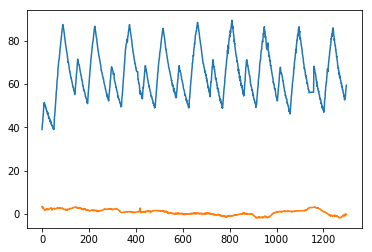

In [54]:
P1dataset = pandas.read_csv('piec.csv', usecols=[2,3], engine='python', skipfooter=3)
#P2dataset= pandas.read_csv('piec.csv', usecols=[2], engine='python', skipfooter=3)
plt.plot(P1dataset)
#plt.plot(P2dataset)
plt.show()

In [55]:
P1dataset.tail(4)

,V1,V2
1295,56.75,0.0
1296,57.25,0.0
1297,58.75,0.0
1298,59.50,-0.2


In [56]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scalerB= MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(P1dataset)
#datasetB = scalerB.fit_transform(P2dataset)


In [57]:
dataset

array([[0.        , 0.96226415],
       [0.03960396, 0.90566038],
       [0.05940594, 1.        ],
       ...,
       [0.36138614, 0.33962264],
       [0.39108911, 0.33962264],
       [0.40594059, 0.30188679]])

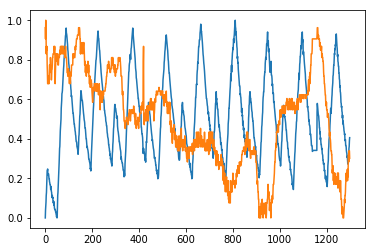

In [58]:
plt.plot(dataset)
#plt.plot(datasetB)
plt.show()

In [59]:
dataset

array([[0.        , 0.96226415],
       [0.03960396, 0.90566038],
       [0.05940594, 1.        ],
       ...,
       [0.36138614, 0.33962264],
       [0.39108911, 0.33962264],
       [0.40594059, 0.30188679]])

In [60]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

870 429


In [61]:
# reshape into X=t and Y=t+1
look_back = 5
window_size=10
trainX, trainY = create_dataset(train, window_size,look_back)
testX, testY = create_dataset(test, window_size,look_back)

In [225]:
testY.shape

(413,)

In [226]:
#trainX[0:8]

In [227]:
trainY[1]

0.20792079207920788

In [228]:
# reshape input to be [samples, time steps, features]
#trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = testX.reshape(testX.shape[0],  testX.shape[1],1)
#testX = testX.reshape(testX.shape + (1,))
#trainX=trainX.reshape(trainX.shape+ (1,))

In [229]:
# reshape input to be [samples, time steps, features]
# when 1 features
#trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [230]:
trainX.shape
#dataset.shape

(854, 2, 10)

In [231]:
trainX.reshape(-1,4)

array([[0.        , 0.03960396, 0.05940594, 0.07920792],
       [0.11386139, 0.12871287, 0.17326733, 0.2029703 ],
       [0.23762376, 0.23762376, 0.96226415, 0.90566038],
       ...,
       [0.32178218, 0.35148515, 0.35849057, 0.39622642],
       [0.33962264, 0.39622642, 0.39622642, 0.39622642],
       [0.43396226, 0.37735849, 0.41509434, 0.43396226]])

In [273]:
# create and fit the LSTM network
print(trainX.shape, trainY.shape)
inp = Input(shape=(2, window_size,))
print('Input',inp.shape)
x = LSTM(128, return_sequences=True)(inp)
print('lstm1',x.shape)
    # The second LSTM can give more fire power to the model, but can overfit it too
#x = LSTM(64, return_sequences=True)(x)
#print('lstn',x.shape)
    # Attention is a new tecnology that can be applyed to a Recurrent NN to give more meanings to a signal found in the middle
    # of the data, it helps more in longs chains of data. A normal RNN give all the responsibility of detect the signal
    # to the last cell. Google RNN Attention for more information :)
x = Attention(2)(x)
print('Atten',x.shape)
#x=RepeatVector(2)(x)
x=Reshape((2,64))(x)
print('Repeat',x.shape)
x = LSTM(64,  return_sequences=False)(x)
    # A intermediate full connected (Dense) can help to deal with nonlinears outputs
x = Dense(64, activation="relu")(x)
    # A binnary classification as this must finish with shape (1,)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)

#model = Sequential()
#model.add(LSTM(4,activation=None ,input_shape=(2,window_size)))
#model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#model.summary()

(854, 2, 10) (854,)
Input (?, 2, 10)
lstm1 (?, ?, 128)
Atten (?, 128)
Repeat (?, 2, 64)


In [281]:
model.fit(trainX, trainY, epochs=30, batch_size=1, verbose=2)

Epoch 1/30
 - 3s - loss: 0.0032
Epoch 2/30
 - 3s - loss: 0.0030
Epoch 3/30
 - 2s - loss: 0.0028
Epoch 4/30
 - 3s - loss: 0.0029
Epoch 5/30
 - 3s - loss: 0.0027
Epoch 6/30
 - 2s - loss: 0.0027
Epoch 7/30
 - 2s - loss: 0.0026
Epoch 8/30
 - 2s - loss: 0.0024
Epoch 9/30
 - 2s - loss: 0.0024
Epoch 10/30
 - 2s - loss: 0.0028
Epoch 11/30
 - 2s - loss: 0.0024
Epoch 12/30
 - 2s - loss: 0.0023
Epoch 13/30
 - 2s - loss: 0.0024
Epoch 14/30
 - 2s - loss: 0.0025
Epoch 15/30
 - 3s - loss: 0.0023
Epoch 16/30
 - 3s - loss: 0.0022
Epoch 17/30
 - 2s - loss: 0.0022
Epoch 18/30
 - 2s - loss: 0.0022
Epoch 19/30
 - 2s - loss: 0.0022
Epoch 20/30
 - 2s - loss: 0.0020
Epoch 21/30
 - 2s - loss: 0.0022
Epoch 22/30
 - 2s - loss: 0.0022
Epoch 23/30
 - 3s - loss: 0.0020
Epoch 24/30
 - 3s - loss: 0.0021
Epoch 25/30
 - 3s - loss: 0.0019
Epoch 26/30
 - 3s - loss: 0.0020
Epoch 27/30
 - 3s - loss: 0.0020
Epoch 28/30
 - 3s - loss: 0.0021
Epoch 29/30
 - 3s - loss: 0.0019
Epoch 30/30
 - 3s - loss: 0.0019


In [282]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict[0]

array([0.30703232], dtype=float32)

In [283]:
#trainPredict.reshape(-1)
#trainPb = numpy.append(trainPredict,numpy.zeros([len(trainPredict),1]),1)
#trainYb=numpy.append(trainY,numpy.zeros([len(trainY),1]),0)
#testPredict.reshape(-1)
trainYY=trainY.reshape(trainY.shape+(1,))
testYY=testY.reshape(testY.shape+(1,))
testYY[1:10]


array([[0.49009901],
       [0.49009901],
       [0.46534653],
       [0.45049505],
       [0.42574257],
       [0.40594059],
       [0.40594059],
       [0.3960396 ],
       [0.38613861]])

In [284]:
#x=[trainY,trainY]
#yy= scaler.inverse_transform(x)
testPredictA=testPredict-testYY
testPredictA[1:10]

array([[-0.0160926 ],
       [-0.02419766],
       [-0.00250654],
       [-0.00737534],
       [ 0.00529151],
       [ 0.00910061],
       [ 0.00576705],
       [-0.00795251],
       [-0.01742911]])

In [285]:
# convert an array of values into a dataset matrix
def inverse_dataset(_scaler,dset):
    x=numpy.append(dset,dset,1)
    yy= _scaler.inverse_transform(x)
    return yy[:,0]

In [286]:
# invert predictions
trainSPredict = inverse_dataset(scaler,trainPredict)
trainSY = inverse_dataset(scaler,trainYY)
#trainSPredict
#testPredict = inverse_dataset(testPredict)
#testY = inverse_dataset([testY])

In [287]:
# calculate root mean squared error
wws=window_size+look_back-1
#trainScore = math.sqrt(mean_squared_error(dataset[wws:len(trainY)+wws,0], trainY))
trainScore = math.sqrt(mean_squared_error( trainY,trainPredict))
print('Train Score: %.5f RMSE' % (trainScore))
trainSScore = math.sqrt(mean_squared_error(trainSY, trainSPredict))
print('Train SScore: %.5f RMSE' % (trainSScore))
testScore = math.sqrt(mean_squared_error(testYY, testPredict))
print('Test Score: %.3f RMSE' % (testScore))

Train Score: 0.03947 RMSE
Train SScore: 1.99309 RMSE
Test Score: 0.050 RMSE


In [288]:
import datetime

with open('lstmpiec.log','a') as f:
    f.write("%s piecAtt: train %.5f  test %.3f  RSME dataset %s\n" %
         ( datetime.datetime.now(),trainScore, testScore,dataset.shape))

#tf.summary.scalar('Test_score_RMSE', testScore)


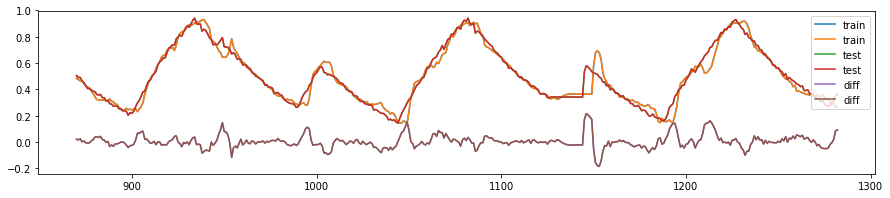

In [294]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
wws=window_size+look_back;
trainPredictPlot[wws:len(trainPredict)+wws, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+wws+1:len(dataset)-window_size-look_back-1, :] = testPredict

testSourcePlot = numpy.empty_like(dataset)
testSourcePlot[:, :] = numpy.nan
testSourcePlot[len(trainPredict)+wws+1:len(dataset)-window_size-look_back-1, :] = testYY

diffPlot=testYY-testPredict
diffPredictPlot = numpy.empty_like(dataset)
diffPredictPlot[:, :] = numpy.nan
diffPredictPlot[len(trainPredict)+wws+1:len(dataset)-window_size-look_back-1, :] = diffPlot
# plot baseline and predictions

fig, ax1 = plt.subplots(figsize=(15,3))
#ax2 = ax1.twinx()
#ax1.plot(scaler.inverse_transform(dataset),label="set")
ax1.plot(testPredictPlot,label="train")
ax1.plot(testSourcePlot,label="test")
ax1.plot(diffPredictPlot,label="diff")
plt.legend()
plt.show()

In [47]:
testPredictPlot

array([[nan, nan],
       [nan, nan],
       [nan, nan],
       ...,
       [nan, nan],
       [nan, nan],
       [nan, nan]])